In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [ ]:

class AttentionPooling(nn.Module):
    def __init__(self, in_features, hidden_features=None):
        super().__init__()
        if hidden_features is None:
            hidden_features = in_features // 2
            
        # Two-layer attention network
        self.attention_network = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.Tanh(),  # Tanh is commonly used for attention stability
            nn.Linear(hidden_features, 1)
        )
    
    def forward(self, x):
        print(x.shape)
        # x shape: [batch_size, channels, sequence_length]
        batch_size, n_channels, seq_length = x.shape

        
        # Transpose to [batch_size, sequence_length, channels]
        x_trans = x.transpose(1, 2)
        print(f"transposed {x_trans.shape}")
        
        # Calculate attention scores
        attention_scores = self.attention_network(x_trans)

        print(f"attention scores {attention_scores.shape}")
        
        # Apply softmax to get attention weights across the sequence length
        attention_weights = F.softmax(attention_scores, dim=1)

        print(f"attention weights {attention_weights.shape}")
        
        # Apply attention weights to input features
        weighted_features = x_trans * attention_weights

        print(f"weighted_features {weighted_features.shape}")
        
        # Sum across sequence length to get final pooled features
        pooled_features = weighted_features.sum(dim=1)

        print(f"pooled features {pooled_features.shape}")
        
        return pooled_features, attention_weights

# Visualization function
def visualize_attention_example():
    batch_size, channels, seq_length = 64, 256, 1000
    x = torch.randn(batch_size, channels, seq_length)
    
    attention_pool = AttentionPooling(channels)
    pooled, weights = attention_pool(x)
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    fig.suptitle("Attention Pooling Visualization")
    
    # Input sequence for one channel
    axs[0].plot(x[0, :, :].cpu().detach().numpy(), color='blue')
    axs[0].set_title("Input Sequence (Channel 0, First Batch)")
    axs[0].set_xlabel("Sequence Length")
    axs[0].set_ylabel("Input Value")
    
    # Attention weights for the same channel
    axs[1].plot(weights[0, :, 0].cpu().detach().numpy(), color='green')
    axs[1].set_title("Attention Weights (Channel 0, First Batch)")
    axs[1].set_xlabel("Sequence Length")
    axs[1].set_ylabel("Weight Value")
    
    # Pooled output across channels
    axs[2].bar(range(channels), pooled[0].cpu().detach().numpy(), color='purple')
    axs[2].set_title("Pooled Output (First Batch)")
    axs[2].set_xlabel("Channels")
    axs[2].set_ylabel("Pooled Value")
    
    plt.tight_layout()
    plt.show()




torch.Size([64, 256, 1000])
transposed torch.Size([64, 1000, 256])
attention scores torch.Size([64, 1000, 1])
attention weights torch.Size([64, 1000, 1])
weighted_features torch.Size([64, 1000, 256])
pooled features torch.Size([64, 256])


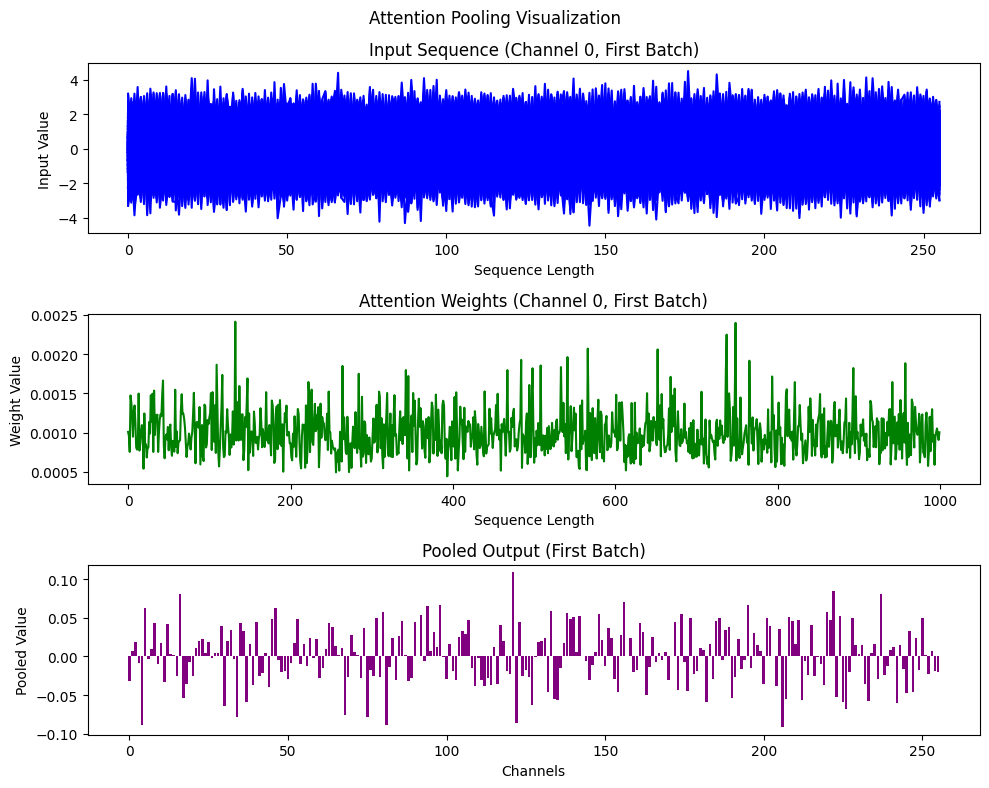

In [6]:
visualize_attention_example()

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('../..')))

from models._model import CBPLTrainer

In [3]:
config = {
    "peak_regions":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/Microglia_peak_set_2.bed",
    "nonpeak_regions":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/test.chr1.negatives.adjusted.bed",
    "genome_fasta":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa",
    "cts_bw_file":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/nd_Microglia_merge.bw",
    "negative_sampling_ratio":0,
    #"train_size": 0.9,
    "batch_size": 64,
    "filters": 256,
    "n_dil_layers":11,
    "conv1_kernel_size": 15,
    "dilation_kernel_size" : 2,
    "num_tasks": 1,
    "input_seq_len": 6000,
    "out_pred_len": 750,
    "learning_rate": 0.001,
    "dropout_rate" : 0.1,
    "train_chrs" : ["chr1","chr2","chr3","chr4","chr5"],
    "valid_chrs" : ["chr6","chr7"],
    "seq_focus_len" : 500,
    "loss" : "weighted_norm_mse",
    "use_attention_pooling" : True
}

In [4]:
trainer = CBPLTrainer(config,checkpoint_path="../cbpl_microglia/97m78wtc/checkpoints/cbpl-epoch=17-val_loss=0.00.ckpt")

Read in bed file of 151351 regions
Read in bed file of 16900 regions
Loaded 151351 peak regions and 0 non-peak regions
Loading model from checkpoint: ../cbpl_microglia/97m78wtc/checkpoints/cbpl-epoch=17-val_loss=0.00.ckpt


In [5]:
trainer.model.eval()

BPNetLightning(
  (eval_metrics): ModuleDict(
    (weighted_norm_mse): WeightedMSELossNorm()
    (weighted_norm_mse_scaled): WeightedMSELossNorm()
    (focused_mse): FocusedMSELoss()
    (mse): MSELoss()
    (kl_divergence): KLDivergence()
    (explained_variance): ExplainedVariance()
    (cosine_similarity): CosineSimilarity()
    (mae): MeanAbsoluteError()
    (r2): R2Score()
  )
  (initial_conv): CNNModule(
    (conv): Conv1d(4, 256, kernel_size=(15,), stride=(1,))
    (activation): ReLU()
  )
  (dilated_convs): ModuleList(
    (0): DilatedConvModule(
      (conv): Conv1d(256, 256, kernel_size=(2,), stride=(1,), dilation=(2,))
      (activation): ReLU()
    )
    (1): DilatedConvModule(
      (conv): Conv1d(256, 256, kernel_size=(2,), stride=(1,), dilation=(4,))
      (activation): ReLU()
    )
    (2): DilatedConvModule(
      (conv): Conv1d(256, 256, kernel_size=(2,), stride=(1,), dilation=(8,))
      (activation): ReLU()
    )
    (3): DilatedConvModule(
      (conv): Conv1d(256,

In [21]:
from utils.attention_utils import get_attention_weights, visualize_attention

In [7]:
for batch in trainer.train_dataloader:
    inputs, targets = batch
    break  

In [11]:
inputs

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 1.]],

        ...,

        [[0., 1., 0.,  ..., 0., 0., 1.],
         [1., 0., 1.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 0., 1.],
         [1., 0., 1.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 1., 0.,  ..., 0., 1

In [13]:
next(trainer.model.parameters()).device

device(type='cuda', index=0)

In [16]:
model =trainer.model.to('cpu')

In [17]:
_ = trainer.model(inputs)

In [20]:
get_attention_weights(trainer.model)

tensor([[[2.9251e-05],
         [4.1632e-05],
         [3.0897e-05],
         ...,
         [3.0897e-05],
         [5.7210e-05],
         [3.0897e-05]],

        [[9.7431e-05],
         [1.1265e-04],
         [1.5460e-04],
         ...,
         [1.1265e-04],
         [2.8936e-05],
         [3.5190e-05]],

        [[6.1803e-05],
         [3.7366e-05],
         [6.1803e-05],
         ...,
         [2.6035e-04],
         [2.8292e-04],
         [1.9509e-03]],

        ...,

        [[1.5762e-04],
         [2.1238e-04],
         [7.2276e-03],
         ...,
         [4.7383e-05],
         [3.7263e-05],
         [3.7263e-05]],

        [[5.1325e-03],
         [2.8545e-04],
         [1.1230e-04],
         ...,
         [6.1056e-05],
         [2.2180e-03],
         [2.3430e-05]],

        [[1.7195e-05],
         [1.7195e-05],
         [2.1865e-05],
         ...,
         [6.3207e-04],
         [6.1475e-04],
         [5.9265e-05]]], grad_fn=<SoftmaxBackward0>)

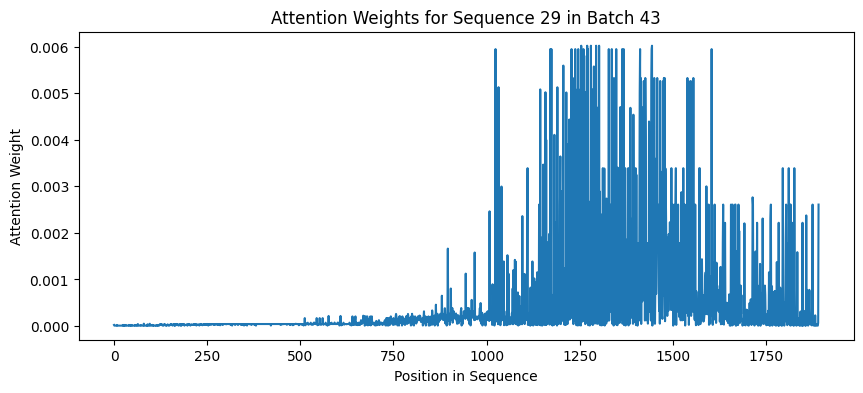

array([2.3604262e-05, 9.0580434e-06, 9.0580434e-06, ..., 9.0580434e-06,
       6.9787005e-05, 2.6085174e-03], dtype=float32)

In [26]:
visualize_attention(trainer.model,29,43)

AttributeError: 'BPNetLightning' object has no attribute 'last_attention_weights'